In [1]:
from __future__ import annotations

import argparse
import math
import os
from pathlib import Path
from typing import List, Tuple

from PIL import Image
from torch.utils.data import Dataset

Datastes&Prepare

In [29]:
class HandwritingDataset(Dataset):
    """Loads (image, transcription) pairs listed in a TSV file.

    Each line in *label_file* should be:  <img_rel_path>\t<label>\n
    Images are resized to fixed *target_height* while preserving aspect ratio.
    """

    def __init__(
        self,
        data_root: str | Path,
        label_file: str | Path,
        char2idx: dict[str, int],
        target_height: int = 64,
    ) -> None:
        super().__init__()
        self.data_root = Path(data_root)
        self.samples: List[Tuple[Path, str]] = []
        with open(label_file, "r", encoding="utf-8") as f:
            for line in f:
                img_rel, label = line.rstrip("\n").split("\t", 1)
                img_name = os.path.basename(img_rel)  # ✅ 只取文件名部分
                self.samples.append((self.data_root / img_name, label))

        self.char2idx = char2idx
        self.blank_idx = len(char2idx)  # final slot reserved for blank
        self.to_tensor = transforms.ToTensor()  # converts HWC [0,255] -> CHW [0,1]
        self.target_height = target_height
    def _text_to_indices(self, text: str) -> List[int]:
        # Replace '|' with space (same logic as TF script)
        return [self.char2idx.get(ch, self.blank_idx) for ch in text.replace("|", " ")]

    def _resize_keep_ratio(self, img: Image.Image) -> Image.Image:
        if img.height == self.target_height:
            return img
        ratio = self.target_height / img.height
        new_w = max(1, int(img.width * ratio))
        return img.resize((new_w, self.target_height), Image.Resampling.LANCZOS)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert("L")  # grayscale
        img = self._resize_keep_ratio(img)
        img_tensor = self.to_tensor(img)  # (1, H, W) float32 in [0,1]
        seq = torch.tensor(self._text_to_indices(label), dtype=torch.long)
        return img_tensor, seq    


In [30]:
def pad_collate(batch, blank_idx: int, downsample_factor: int):
    """Pads images & labels in a batch, returning tensors required by CTC."""
    imgs, labels = zip(*batch)

    # --- pad images to max width ---
    heights = [im.shape[1] for im in imgs]
    assert len(set(heights)) == 1, "all images must share the target height"
    max_w = max(im.shape[2] for im in imgs)
    padded_imgs = []
    for im in imgs:
        pad_w = max_w - im.shape[2]
        padded = F.pad(im, (0, pad_w, 0, 0), value=1.0)  # right‑pad with white
        padded_imgs.append(padded)
    image_batch = torch.stack(padded_imgs)  # (B, 1, H, W)

    # --- pad label sequences ---
    label_lens = torch.tensor([len(l) for l in labels], dtype=torch.long)
    max_lab = max(label_lens)
    padded_labels = torch.full((len(labels), max_lab), blank_idx, dtype=torch.long)
    for i, seq in enumerate(labels):
        padded_labels[i, : len(seq)] = seq

    # CTC expects (T, B, C); we also need input_lengths after CNN down‑sampling
    input_lens = torch.full(
        (len(labels),),
        fill_value=math.floor(max_w / downsample_factor),
        dtype=torch.long,
    )
    return image_batch, padded_labels, input_lens, label_lens

Model

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [39]:
class CNNEncoder(nn.Module):
    def __init__(self, d_model=256):
        super().__init__()
        resnet = models.resnet18(weights=None)
        modules = list(resnet.children())[:-2]  
        self.backbone = nn.Sequential(*modules)  

        self.conv1x1 = nn.Conv2d(512, d_model, kernel_size=1) 
        self.flatten = nn.Flatten(2) 
        self.permute = lambda x: x.permute(0, 2, 1) 

    def forward(self, x):  # x: (B, 1, H, W)
        x = x.expand(-1, 3, -1, -1) 
        feat = self.backbone(x)  # (B, 512, H', W')
        feat = self.conv1x1(feat)  # (B, d_model, H', W')
        seq = self.flatten(feat)   # (B, d_model, T)
        return self.permute(seq)   # (B, T, d_model)



In [40]:
class TransformerDecoderOCR(nn.Module):
    def __init__(self, vocab_size, d_model=256, nhead=4, num_layers=3, dropout=0.1, max_len=100):
        super().__init__()
        self.d_model = d_model
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pos_embed = nn.Parameter(torch.randn(1, max_len, d_model))  # learnable positional embedding
        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, d_model*2, dropout, batch_first=True)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers)
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, tgt_seq, memory):
        # tgt_seq: (B, T_dec) - token ids with <sos> at start
        # memory: (B, T_enc, d_model) - CNN features
        B, T = tgt_seq.size()
        tgt_embed = self.embed(tgt_seq) + self.pos_embed[:, :T, :]
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(T).to(tgt_seq.device)
        output = self.transformer_decoder(tgt_embed, memory, tgt_mask=tgt_mask)
        return self.fc(output)  # (B, T, vocab_size)

In [41]:
class OCRTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=256, max_len=100):
        super().__init__()
        self.encoder = CNNEncoder(d_model)
        self.decoder = TransformerDecoderOCR(vocab_size, d_model, max_len=max_len)

    def forward(self, images, tgt_input):  # images: (B, 1, H, W), tgt_input: (B, T)
        memory = self.encoder(images)      # (B, T_enc, d_model)
        logits = self.decoder(tgt_input, memory)  # (B, T_dec, vocab_size)
        return logits


Model Training

In [47]:
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.models as models


In [43]:
def build_vocab(label_file: str | Path):
    text = ""
    with open(label_file, "r", encoding="utf-8") as f:
        for line in f:
            _img, lbl = line.rstrip("\n").split("\t", 1)
            text += lbl.replace("|", " ")
    vocab = sorted(set(text))
    char2idx = {c: i + 3 for i, c in enumerate(vocab)}
    char2idx['<pad>'] = 0
    char2idx['<sos>'] = 1
    char2idx['<eos>'] = 2
    idx2char = {i: c for c, i in char2idx.items()}
    return char2idx, idx2char


In [44]:
label_file = "train_data/rec/rec_gt_train.txt"
char2idx, idx2char = build_vocab(label_file)
pad_id = char2idx['<pad>']
sos_id = char2idx['<sos>']
eos_id = char2idx['<eos>']


In [45]:
train_dataset = HandwritingDataset(
    data_root="train_data/rec/train",
    label_file=label_file,
    char2idx=char2idx
)

def collate_batch(batch, pad_id, sos_id):
    # 图片padding to max width
    from torch.nn.utils.rnn import pad_sequence
    imgs, labels = zip(*batch)
    max_width = max(img.shape[-1] for img in imgs)
    padded_imgs = [nn.functional.pad(img, (0, max_width - img.shape[-1])) for img in imgs]
    imgs_tensor = torch.stack(padded_imgs)

    inputs = [[sos_id] + seq.tolist() for seq in labels]
    targets = [seq.tolist() + [eos_id] for seq in labels]
    input_tensor = pad_sequence([torch.tensor(s) for s in inputs], batch_first=True, padding_value=pad_id)
    target_tensor = pad_sequence([torch.tensor(s) for s in targets], batch_first=True, padding_value=pad_id)
    return imgs_tensor, input_tensor, target_tensor

In [ ]:
# ===== 3. 模型训练 =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = OCRTransformer(vocab_size=len(char2idx), d_model=256, max_len=100).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=pad_id)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                          collate_fn=lambda b: collate_batch(b, pad_id, sos_id))
for epoch in range(10):
    loss = train_one_epoch(
        model, train_loader, criterion, optimizer,
        device, pad_id, step=epoch*len(train_loader)
    )
    print(f"Epoch {epoch}: Train loss = {loss:.4f}")


  step 000000  batch_loss=4.5354
  step 000001  batch_loss=4.2061
  step 000002  batch_loss=3.9647
  step 000003  batch_loss=3.7531
  step 000004  batch_loss=3.6387
  step 000005  batch_loss=3.4961
  step 000006  batch_loss=3.4491
  step 000007  batch_loss=3.4218
  step 000008  batch_loss=3.3856
  step 000009  batch_loss=3.3439
  step 000010  batch_loss=3.2748
  step 000011  batch_loss=3.3219
  step 000012  batch_loss=3.2734
  step 000013  batch_loss=3.2509
  step 000014  batch_loss=3.2498


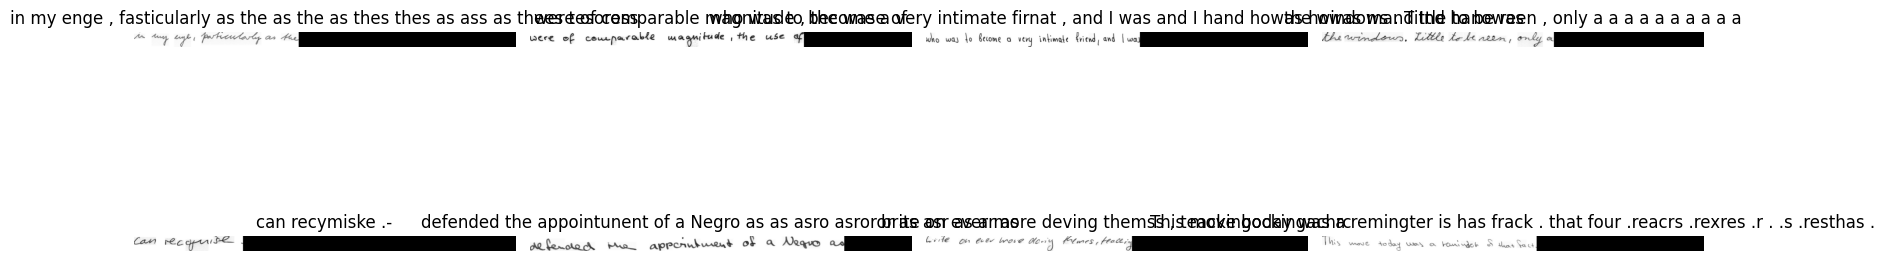

In [49]:
import matplotlib.pyplot as plt

model.eval()

images, _, _ = next(iter(train_loader))
images = images.to(device)

preds = greedy_decode(model, images[:8], sos_id, eos_id, max_len=100, idx2char=idx2char)

def show_images_with_preds(images, preds):
    fig, axes = plt.subplots(2, 4, figsize=(16, 6))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        img = images[i].cpu().squeeze(0).squeeze(0).numpy()  # (1, H, W) -> (H, W)
        ax.imshow(img, cmap='gray')
        ax.set_title(preds[i], fontsize=12)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

show_images_with_preds(images[:8], preds)


In [50]:
pip install jiwer


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 1.8 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 2.5 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [51]:
from jiwer import cer, wer

def evaluate_ocr(model, data_loader, device, sos_id, eos_id, idx2char, pad_id, max_len=100):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, _, targets in data_loader:
            images = images.to(device)
            targets = targets.cpu().tolist()

            preds = greedy_decode(model, images, sos_id, eos_id, max_len, idx2char)

            for pred, target in zip(preds, targets):
                target_text = "".join([idx2char[i] for i in target if i != pad_id and i != eos_id])
                all_preds.append(pred)
                all_targets.append(target_text)

    character_error = cer(all_targets, all_preds)
    word_error = wer(all_targets, all_preds)
    return character_error, word_error

cer_score, wer_score = evaluate_ocr(
    model, train_loader, device, sos_id, eos_id, idx2char, pad_id
)

print(f"Character Error Rate (CER): {cer_score:.4f}")
print(f"Word Error Rate (WER): {wer_score:.4f}")


Character Error Rate (CER): 0.5314
Word Error Rate (WER): 0.6881
